In [1]:
from data import wiki
from data import corpus
import alignment

import nltk
import pandas as pd
import pickle
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

posts = wiki.load_posts()
users = wiki.load_users(posts=posts)

markers = alignment.load_markers()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [2]:
posts['post_len'] = posts['tokens'].apply(len) # length of 'b' posts

for m in markers: # binary marker presence
    posts[m+'_bin'] = posts[m] > 0

# set up dataframe of reply pairs (a,b) 
pairs = corpus.get_reply_pairs(posts)
df = pairs\
    .merge(users.add_suffix('_a'), how='left', left_on='user_a', right_index=True)\
    .merge(users.add_suffix('_b'), how='left', left_on='user_b', right_index=True)

In [3]:
# compute condintions for alignment measurement
centrality_threshold = users.centrality.mean() + users.centrality.std()
df['highly_central_a'] = df.centrality_a > centrality_threshold
df['admin_at_time_a'] = df.timestamp_b > df.admin_ascension_a

In [4]:
# compute overall marker frequency
marker_freq = dict(posts[list(markers)].sum() / posts['post_len'].sum())

In [5]:
def scp(a):
    """ `a` is a dataframe containing reply pairs where user_a is a member
        of the desired group A.
        `marker_freq` is a dictionary from markers to overall frequencies
        in the whole corpus.
    """
    def scp_m(m):

        # TODO: implement bootstrap resampling for confidence?

        base_prob = a.groupby('user_b')[m+'_bin_b'].mean()
        cond_prob = a[a[m+'_bin_a']].groupby('user_b')[m+'_bin_b'].mean()
        
        return cond_prob - base_prob

    return pd.DataFrame({m: scp_m(m) for m in markers})

In [6]:
def wscp(a):
    """ `a` is a dataframe containing reply pairs where user_a is a member
        of the desired group A.
        `marker_freq` is a dictionary from markers to overall frequencies
        in the whole corpus.
    """
    def wscp_m(m):

        base_m_count = a.groupby('user_b')[m+'_b'].sum()
        base_word_count = a.groupby('user_b')['post_len_b'].sum()
        base_prob = base_m_count / base_word_count

        cond_m_count = a[a[m+'_bin_a']].groupby('user_b')[m+'_b'].sum()
        cond_word_count = a[a[m+'_bin_a']].groupby('user_b')['post_len_b'].sum()
        cond_prob = cond_m_count / cond_word_count
        
        return (cond_prob - base_prob) / marker_freq[m]

    return pd.DataFrame({m: wscp_m(m) for m in markers})


In [7]:
def agg1(df):
    """ Computes "Aggregated 1" as described in Echoes of Power.
        Drop any users missing any of the values.
    """
    return df.dropna().mean(axis=1)

def agg2(df):
    """ Computes "Aggregated 2" as described in Echoes of Power.
        Fill missing values with the group average
    """ 
    return df.fillna(df.mean()).mean(axis=1)

def agg3(df):
    """ Computes "Aggregated 3" as described in Echoes of Power.
        Fill missing values with the per-user mean of the other markers.
    """ 
    return df.transpose().fillna(df.mean(axis=1)).transpose().mean(axis=1)

def coord_with_aggs(coord_measure, a):
    coords = coord_measure(a)
    aggs = pd.Series([agg1(coords).mean(), agg2(coords).mean(), agg3(coords).mean()], index=['agg1', 'agg2', 'agg3'])
    return aggs.append(pd.Series(coords.mean()))

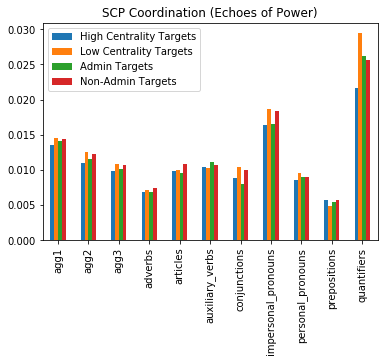

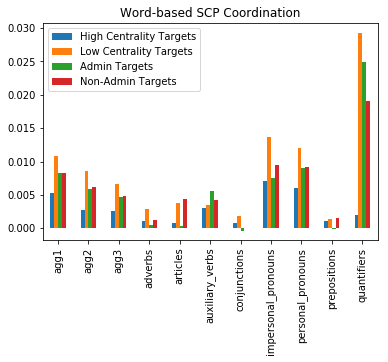

In [8]:
%matplotlib inline

conditions = [
        ('High Centrality Targets', df[df['highly_central_a']]),
        ('Low Centrality Targets', df[~df['highly_central_a']]),
        ('Admin Targets', df[df['admin_at_time_a']]),
        ('Non-Admin Targets', df[~df['admin_at_time_a']])]
labels, dfs = zip(*conditions)

title1="SCP Coordination (Echoes of Power)"
pd.DataFrame({group: coord_with_aggs(scp, group_df) for group, group_df in conditions}, columns=labels).plot.bar(title=title1)
title2="Word-based SCP Coordination"
pd.DataFrame({group: coord_with_aggs(wscp, df) for group, df in conditions}, columns=labels).plot.bar(title=title2)


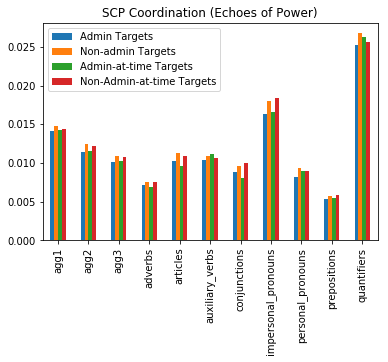

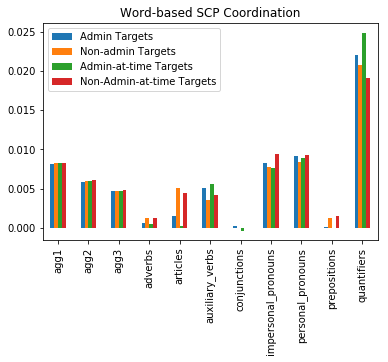

In [9]:
%matplotlib inline

conditions = [
        ('Admin Targets', df[df['admin_a']]),
        ('Non-admin Targets', df[~df['admin_a']]),
        ('Admin-at-time Targets', df[df['admin_at_time_a']]),
        ('Non-Admin-at-time Targets', df[~df['admin_at_time_a']])
        ]
labels, dfs = zip(*conditions)

title1="SCP Coordination (Echoes of Power)"
pd.DataFrame({group: coord_with_aggs(scp, group_df) for group, group_df in conditions}, columns=labels).plot.bar(title=title1)
title2="Word-based SCP Coordination"
pd.DataFrame({group: coord_with_aggs(wscp, df) for group, df in conditions}, columns=labels).plot.bar(title=title2)
